# Analysis of Titanic Data Using Numpy and Pandas

In this project, I'll be exploring Kaggle dataset on 891 Titanic passengers. The biggest question I could ask of this dataset is: **What were the most likely factors for survival?** By the end of this notebook, I'll suggest a simple heuristic based on some of these factors that aims to make a tentative prediction. This heuristic is merely a sanity check and by no means a conclusive predictor for survival. Along the way, I'll explore some other questions that come up as I perform the analysis, such as:

 * How do we deal with missing data?
 * Are higher class tickets necessarily more expensive?
 * How are survival factors interrelated?

among others.

*Note: I have implemented CSS style files `style-table.css` and `style-notebook.css` from Brandon Rhodes' pandas tutorial [GitHub page](https://github.com/brandon-rhodes/pycon-pandas-tutorial) to make the dataframe tables more visually appealing.*

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

# change visual style of pandas dataframe tables
from IPython.core.display import HTML
css = open('style-table.css').read()
HTML('<style>{}</style>'.format(css))

Populating the interactive namespace from numpy and matplotlib


First of all, let us examine what sort of data is in each column. Based the [Kaggle website description of the dataset](https://www.kaggle.com/c/titanic/data), here's a brief description of the data features:

 Variable      | Description   
 ------------- |-------------
 PassengerId   | Passenger index
 Survived      | **1** for yes or **0** for no 
 Pclass        | Class: **1**st, **2**nd, or **3**rd
 Sex           | Sex (**male**/**female**)
 Age           | Age (in years)
 SibSp         | Number of siblings/spouses aboard
 Parch         | Number of parents/children aboard
 Ticket        | Ticket number (string)
 Fare          | Price of ticket
 Cabin         | Cabin number (string)
 Embarked      | Point of embarkation: **C** = Cherbourg, **Q** = Queenstown, **S** = Southampton

At this point, it seems like the most promising features that determine survival are `Pclass`, `Sex`, `Age`, `SibSp` & `Parch` (for family size), `Fare`, and `Embarked`. These features are either categorical (`Sex`, `Pclass`, `Embarked`) or numerical in nature.


## Handling Missing Data

Let us first figure out where and how to fill in missing data. Using `info()`, we can see which columns of the data have null values. Let's see which columns have missing data:

In [2]:
df = pd.read_csv('titanic-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


It looks like there are **three** columns with missing data: `Age`, `Cabin`, and `Embarked`. Cabin data is sparse and relatively uninformative, so let us not bother with that column at this time. Let us also drop the redundant `PassengerId` index column to save space.

### Embarkation

There are two missing values in the `Embarked` column. Let's see what they are:

In [3]:
# remove PassengerId and Cabin columns, and find rows where Embarked has null values
df = df.drop(['PassengerId','Cabin'], axis=1)
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


Instead of simply ignoring these passengers' point of embarkation or filling it in with "S" (Southampton was the port with the most embarkations), let us use the data to help us make the right decision. This is where it may be useful to see what the relationships between passenger class, fare, and embarkation point are. 

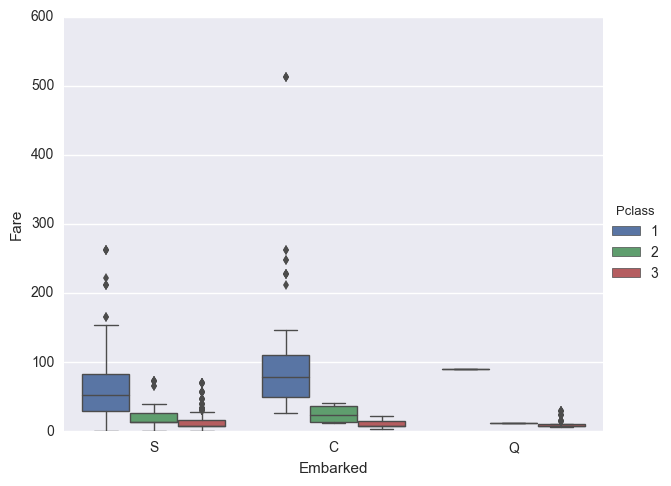

In [4]:
# boxplots of first class fares by embarkation point
box = sns.factorplot('Embarked', 'Fare', hue='Pclass', data=df, \
                     kind='box', size=5, aspect=1.25, linewidth=1)

There is a wide range of 1st class fares, with many outliers. The general trend shows that fares increase with higher class. Let us zoom in on the interquartile ranges:

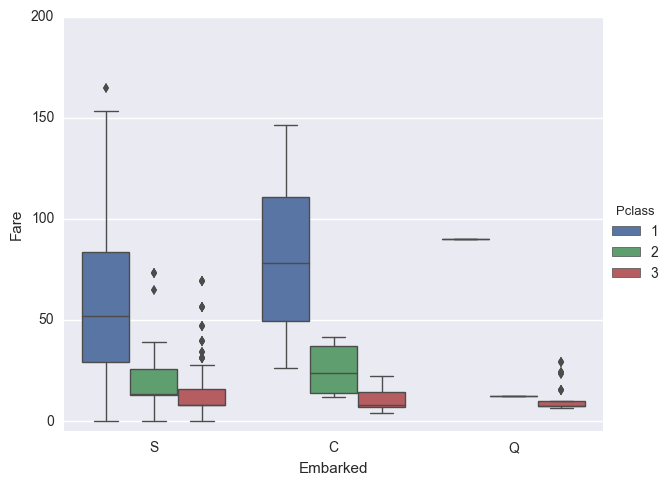

In [5]:
# boxplots of first class fares by embarkation point (inset)
box = sns.factorplot('Embarked', 'Fare', hue='Pclass', data=df, \
                     kind='box', size=5, aspect=1.25, linewidth=1)
box.set(ylim=(-5,200))

Here we have made a series of boxplots for the fares that 1st, 2nd, and 3rd class passengers paid who embarked from each of the three ports. The two female passengers paid 80 (Pounds? Dollars?) for 1st class tickets, so they most likely boarded in Cherbourg, where 80 falls in the middle of the interquartile range for 1st class passengers. We also see a general pattern where higher fares correspond to higher class, although with wider spread for 1st class fares. This answers the fares vs. class question.

In [6]:
# check to see if we filled in the correct cells
df.Embarked.fillna('C', inplace=True)
df.iloc[[61,829]]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,C
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,C


This method of imputation was adapted from [Megan Risdal's excellent R report on Kaggle](https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic/notebook).

### Age

This is a bit trickier because there are many more null entries and factors for which to make an imputation. We could simply fill in the null values with the average male age (for male passengers) or female age (for female passengers). This method may work for general purposes, but I think we can do better than that.

In [7]:
# count null values by sex and class and use unstack() to make each sex a column in the 
# resulting table
null_ages = df[df.Age.isnull()].groupby(['Pclass', 'Sex']).count().Name.unstack()
null_ages

Sex,female,male
Pclass,,
1,9,21
2,2,9
3,42,94


Here we see that the majority of missing ages come from males in 3rd class, and that 3rd class passengers in general have the most missing age data. Many of them tend to have large families with children whose ages are not recorded for some reason or another. To get a handle on how the other ages are distributed by sex, let us take a look at the histogram below[^1]:

[^1]: http://stackoverflow.com/questions/19584029/plotting-histograms-from-grouped-data-in-a-pandas-dataframe was a useful resource for making stacked histograms.

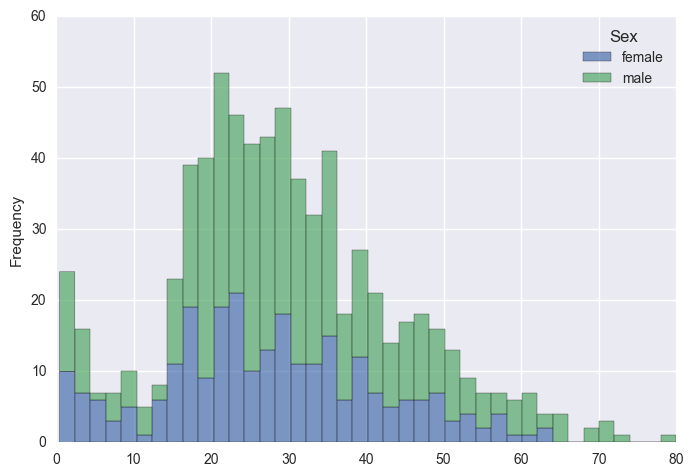

In [8]:
# distribution of ages of passengers by sex
age_sex = df.reset_index().pivot('index', 'Sex', 'Age')
age_sex.plot(kind='hist', bins=40, alpha=0.7, stacked=True)

From here it looks like most passengers aboard were between 20-30 years of age. It might be good to ask: *How do the ages of passengers differ by class?*  Here's the age distribution divided up by class:

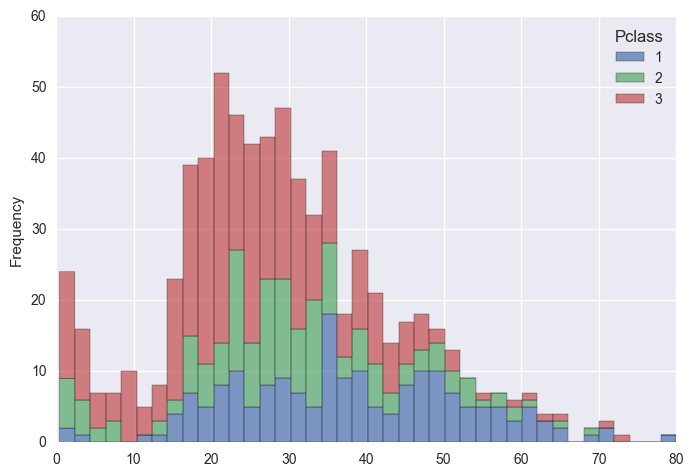

In [9]:
# distribution of ages of passengers by class
age_class = df.reset_index().pivot('index', 'Pclass', 'Age')
age_class.plot(kind='hist', bins=40, alpha=0.7, stacked=True)

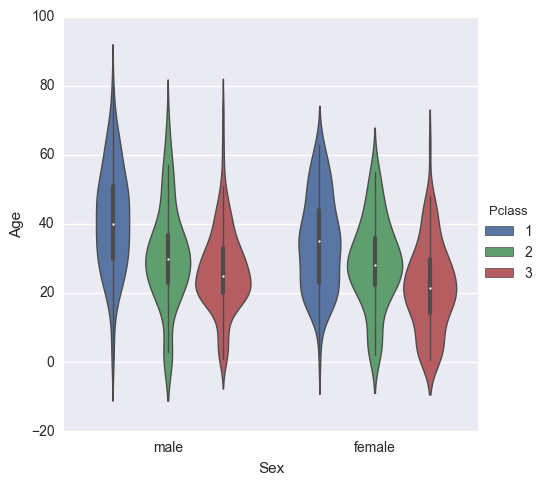

In [10]:
# violin plot of age distributions by class and sex
box = sns.factorplot('Sex', 'Age', hue='Pclass', data=df, \
                     kind='violin', size=5, aspect=1, linewidth=1)

In the histogram, it looks like lower class passengers tend to be younger. In the violin plot above, this trend is more clearly shown, this time split by sex. First class passengers tend to be older on average than 2nd class passengers, who in turn are older than 3rd class passengers. Female distributions skew slightly younger than male ones, but the same trend among classes holds. The averages are listed below.

In [11]:
# find mean ages by class and sex using groupby() and unstack()
age_table = df[['Pclass', 'Sex', 'Age']].groupby(['Pclass', 'Sex']).mean().unstack().Age
age_table.round(2)

Sex,female,male
Pclass,,
1,34.61,41.28
2,28.72,30.74
3,21.75,26.51


Now we are ready to replace the null ages with our best guesses for ages based on the averages calculated above. For each class and sex, we will generate a series of random ages whose average corresponds with that class/sex category[^2]. For example, there are 9 missing ages for 1st class females, so we'll generate a series of 9 random numbers with a mean age of 34.6 to fill in missing data within that category. We continue for each category until all null values are filled. Plots of the age distribution before and after filling are shown below.

[^2]: https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic 

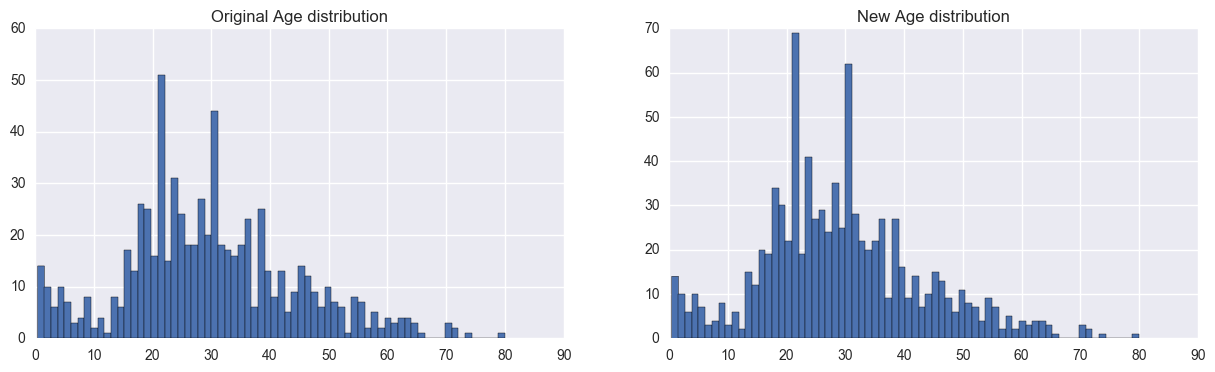

In [12]:
# set age plots
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age distribution')
axis2.set_title('New Age distribution')

# make histogram of original ages
df.Age.dropna().hist(bins=70,ax=axis1)

# find means, standard deviations, and number of null values for age
avg_ages = age_table
std_ages = df[['Pclass', 'Sex', 'Age']].groupby(['Pclass', 'Sex']).std().unstack()['Age']
# null age counts for each category given by the null_ages table

# generate random numbers within one standard deviation of the 
# mean age for each class and sex
classes = [1,2,3]
sexes = ['female', 'male']
for pclass in classes:
    for sex in sexes:
        avg = avg_ages.loc[pclass][sex]
        std = std_ages.loc[pclass][sex]
        num_nulls = null_ages.loc[pclass][sex]
        
        # create random number array
        rand_num = random.randint(avg - std, avg + std, size = num_nulls)

        # create a series of random ages whose indices are the 
        # indices of null values in the original dataframe
        class_sex_df = df[(df.Pclass == pclass) & (df.Sex == sex)]
        null_indices = class_sex_df.Age[class_sex_df.Age.isnull()].index
        new_ages = pd.Series(rand_num, index = null_indices)
        # replace null ages with new ages
        df.Age.fillna(value = new_ages, inplace=True)

# make sure all ages are floats
df['Age'].astype(float)

# make histogram of new ages
df['Age'].hist(bins=70,ax=axis2)

The new distribution of ages looks roughly like the old one, as expected. Let's check to see if we got all null ages filled in.

In [13]:
df[df.isnull()].Age.count()

0

This imputation is not perfect, since there are other factors we could have considered. Some passengers are children in large families, so we cannot assume that the age distribution will stay the same if we guessed their ages more accurately. We also assumed that the age distributions are Gaussian, which is not necessarily the case, given how they look for ages younger than 10.

Of course, there is always the option of ignoring passengers with null age values altogether. But it seems a waste to dispose of an eigth of the dataset for the sake of one variable.  

## Exploring Survival Factors

Now that our data is cleaned, we can take a look at factors that influence survival. A quick way to get an overview is to find the correlation between each potential variable (dependent and independent) using a correlation table. We can do this easily with Pandas' `corr()` function. But `corr()` only works with numerical values. Since the sex of passengers is an important survival factor, we should include it into our correlation calculations. So let us assign a numerical value for each each sex: 0 for males and 1 for females.

In [14]:
df['Sex'] = df.Sex.apply(lambda x: 1 if x == 'female' else 0)

Now we're ready to make a correlation table. Values range from -1 (highly negatively correlated) to 1 (highly positively correlated), with 0 indictating no correlation. A heatmap of these values is shown below the table.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.0000,-0.3385,0.5434,-0.0606,-0.0353,0.0816,0.2573
Pclass,-0.3385,1.0000,-0.1319,-0.4043,0.0831,0.0184,-0.5495
Sex,0.5434,-0.1319,1.0000,-0.1115,0.1146,0.2455,0.1823
Age,-0.0606,-0.4043,-0.1115,1.0000,-0.2594,-0.1732,0.1113
SibSp,-0.0353,0.0831,0.1146,-0.2594,1.0000,0.4148,0.1597
Parch,0.0816,0.0184,0.2455,-0.1732,0.4148,1.0000,0.2162
Fare,0.2573,-0.5495,0.1823,0.1113,0.1597,0.2162,1.0000


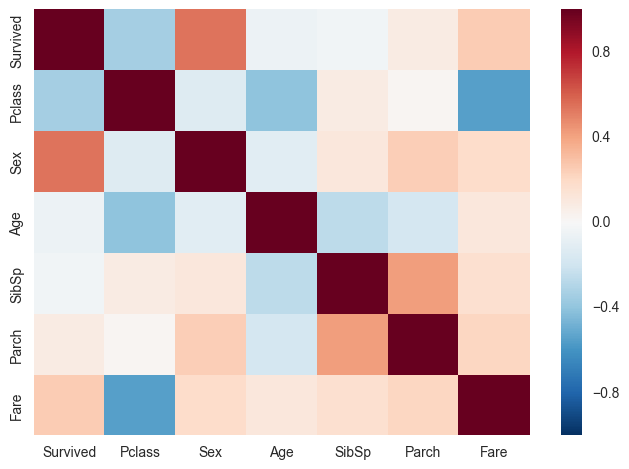

In [15]:
display(df.corr().round(4))
sns.heatmap(df.corr())

Whether or not a passenger survived would be the dependent variable with passenger attributes such as class, sex, age, etc. being independent variables. Our analysis is complicated by the fact that the columns in our dataset all have nonzero correlations with each other, so our "independent variables" are not truly independent. Such is the messy nature of working with real data. Examining the `Survived` row, we find that the highest correlations are with `Pclass`, `Sex`, and `Fare`. Let's take a closer look at how these variables influence survival.

### Sex vs. Survival

The variable with the highest correlation with `Survived` is `Sex` with 0.5434. This correlation is positive, indicating that females are more likely to survive than males. Let's check the numbers:

In [16]:
# add up survivors and total passengers by sex
f = {'Survived': 'sum', 'Ticket': 'count'}
by_sex = df.groupby('Sex').agg(f)
by_sex['pct_of_survivors'] = 100*by_sex['Survived']/(by_sex['Survived'].sum())
by_sex['pct_chance_of_survival'] = 100*by_sex['Survived']/by_sex['Ticket']
by_sex = by_sex.transpose().rename(
    index = {'Ticket':'Total'},
    columns = {0:'male', 1:'female'})
by_sex.round(1)

Sex,male,female
Total,577.0,314.0
Survived,109.0,233.0
pct_of_survivors,31.9,68.1
pct_chance_of_survival,18.9,74.2


Of the 891 passengers in the sample data, 68.1% of passengers who survived were females, and 31.9% were males. A male passenger would have a 18.9% chance of survival and a 74.2% chance if female.

### Fare and Class vs. Survival

As we have seen in a previous section, fare and class are themselves correlated, with high fares corresponding with high class (low value for `Pclass`), with a correlation of -0.5495. But it would still be good for us to examine how fares and class influence survival separately.

**Kernel density estimators** provide an alternative to histograms for plotting distributions of a given variable, especially when it varies continuously. In this case, let us see how the distribution of surviving passengers' fares differs from the fare distribution of those that do not survive.

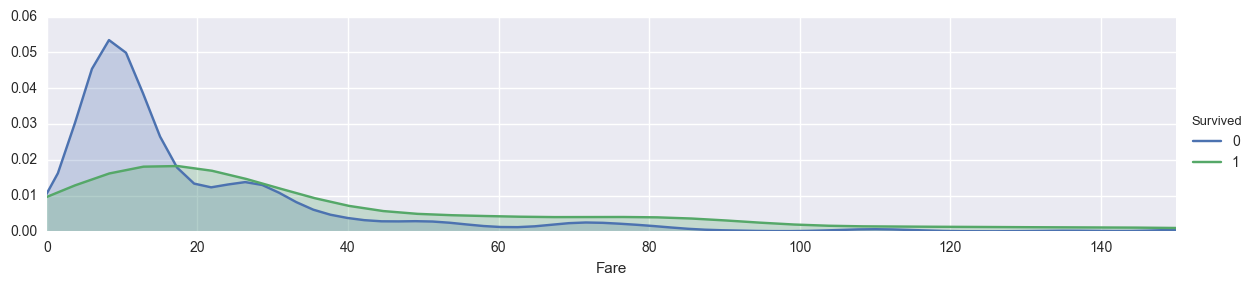

In [17]:
# distribution of fares
fare_kde = sns.FacetGrid(df, hue='Survived', aspect=4)
fare_kde.map(sns.kdeplot, 'Fare', shade=True)
fare_kde.set(xlim= (0, 150))
fare_kde.add_legend()

It looks here like passengers who pay a high fare have a better chance than those who paid low fares. High-fare passengers (1st class) tend to occupy cabins close to lifeboats on the upper decks, while low-fare passengers tend to occupy decks farther away from lifeboats or other means to escape the ship. But this is very close to saying that high-class passengers are more likely to survive.

Let's take a look at class. We count up survivors and victims in each class and plot the results.

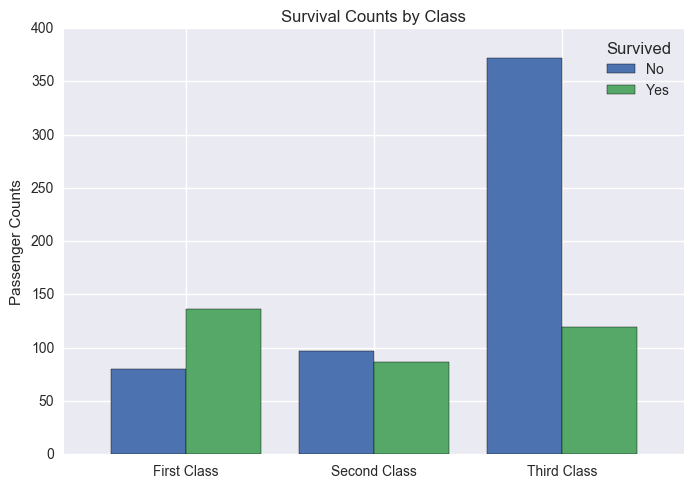

In [18]:
# table of counts of survivors and victims within each class
class_table = df.groupby(['Pclass', 'Survived']).count().Name.unstack('Survived')
class_table.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
p = class_table.plot(kind='bar',width=0.8, rot=0)
p.set_xticklabels(['First Class', 'Second Class', 'Third Class'])
p.set(xlabel = '', ylabel = 'Passenger Counts', title = 'Survival Counts by Class')

As suspected, 1st class is the only class where there were more survivors than victims. If we convert the raw counts into percentage survived or died for each class, we get the following table.

In [19]:
# function for transforming number survived into percent survived within each category
def survival_pct_table(table):
    return 100*table.div(table.sum(axis=1),axis=0)
    
survival_pct_table(class_table)

Survived,No,Yes
Pclass,,
1,37.037037,62.962963
2,52.717391,47.282609
3,75.763747,24.236253


So you would have had a roughly 2/3 chance of surviving if you were in 1st class, a 50-50 chance if you were in 2nd class, and a 1/4 chance if you were in 3rd class.

### Family Size vs. Survival

Another factor that may influence survival is family size. So let us introduce a new column to our dataframe named `Size`, the total number of family members a given passenger has onboard, including the passenger.

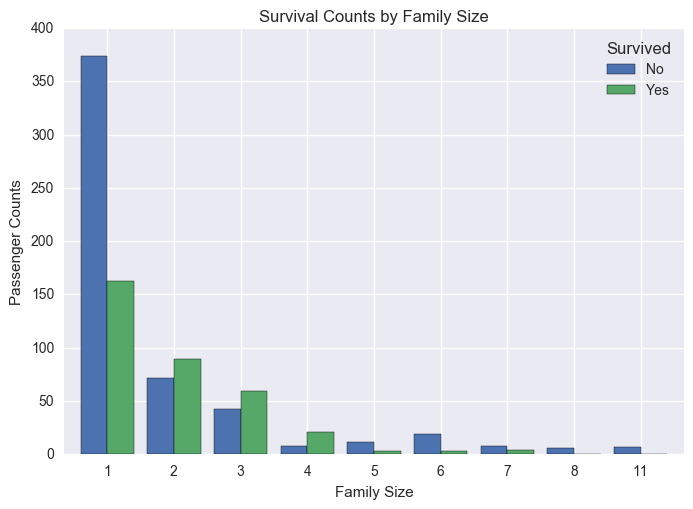

In [20]:
# create new column called Size that adds up SibSp, Parch and the passenger
df['Size'] = df.SibSp + df.Parch + 1

# plot effect of family size on survival
family_size_table = df.groupby(['Size', 'Survived']).count().Name.unstack('Survived').fillna(0)
family_size_table.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
p = family_size_table.plot(kind='bar', width=0.8, rot=0)
p.set(ylabel = 'Passenger Counts', xlabel = 'Family Size', 
      title = 'Survival Counts by Family Size')

So singletons are half as likely to survive than perish, while families with 2-4 members are more likely to survive than perish. Large families with 5 or more members are penalized with lower survival rates. The table below displays survival percentages by family size.

In [21]:
# survival percentages
survival_pct_table(family_size_table).round(1).transpose()

Size,1,2,3,4,5,6,7,8,11
Survived,,,,,,,,,
No,69.6,44.7,42.2,27.6,80.0,86.4,66.7,100.0,100.0
Yes,30.4,55.3,57.8,72.4,20.0,13.6,33.3,0.0,0.0


### Age vs. Survival

Here it is useful to employ a kernel density estimator to see how ages are distributed among survivors and victims.

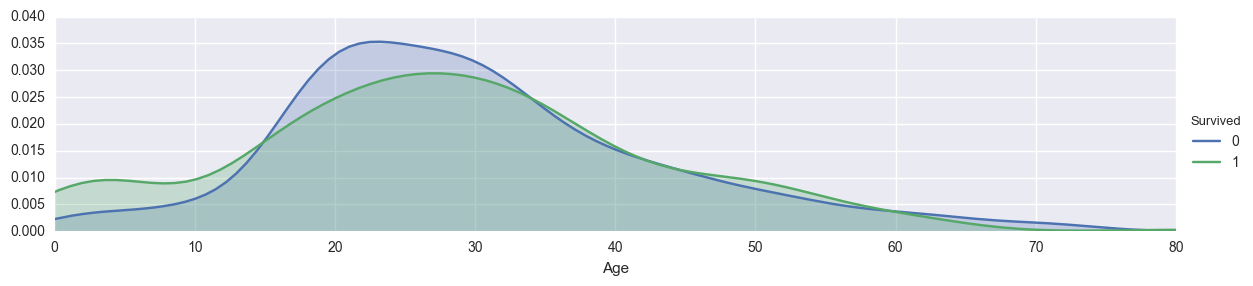

In [22]:
# plot kdes of age distributions among survivors and victims
age_kde = sns.FacetGrid(df, hue='Survived', aspect=4)
age_kde.map(sns.kdeplot, 'Age', shade=True)
age_kde.set(xlim= (0, df.Age.max()))
age_kde.add_legend()

Survivors seem to skew older than victims, with the peak in the survivor distribution in the late-20s and the victim distribution the mid-20s. But this is misleading because there is a larger portion of children under age 10 in the survivor distribution. This brings the average and median ages of survivors and victims to near parity.

In [23]:
df.groupby('Survived').describe().Age.unstack('Survived').round(2)

Survived,0,1
count,549.00,342.00
mean,29.82,28.12
std,13.18,14.40
min,1.00,0.42
25%,21.00,19.00
50%,28.00,27.50
75%,36.00,36.00
max,74.00,80.00


### Title vs. Survival

As a bonus, I've tried my hand at regex to see how a person's title may influence survival. The following code extracts a person's title (Mr, Mrs, Dr, etc.) from their name and creates a new column in the dataframe called `Title`. The `find_surname_title` function has the option to extract the passenger's surname as well.

In [24]:
import re
# use regex to extract the surname and title from a given name
# in df.Names
def find_surname_title(name, **kwargs):
    match = re.search(r'([\w\s]+), ([\w\s]+). ([\w\W]+)', name)
    if match:
        if kwargs['name_type'] == 'surname':
            return match.group(1)
        if kwargs['name_type'] == 'title':
            return match.group(2)

# extract titles and surnames with apply()
titles = df.Name.apply(find_surname_title, name_type = 'title')
surnames = df.Name.apply(find_surname_title, name_type = 'surname')
df['Title'] = titles
titles.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [25]:
len(titles.unique())

17

There are 17 unique monikers that passengers place before their names. Let's see how they are divvied up by sex.

In [26]:
# create table that counts passengers with a given title by sex
titles_v_sex = df.groupby(['Title', 'Sex']).count().Name.unstack('Sex')
titles_v_sex.rename(columns = {0:'male', 1:'female'}, inplace=True)
titles_v_sex.fillna(0, inplace=True)
titles_v_sex.astype(int).transpose()

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1


All but one of these titles are sex-segregated. There are 7 passengers with the title 'Dr', 6 males and 1 female. As it happened, that female doctor survived.

In [27]:
df[(df.Title == 'Dr') & (df.Sex == 1)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Size,Title
796,1,1,"Leader, Dr. Alice (Farnham)",1,49.0,0,0,17465,25.9292,S,1,Dr


Let's see how many people with each title survived.

In [28]:
# create table that counts passengers with a given title by survival
title_table = df.groupby(['Title','Survived']).count().Name.unstack('Survived')
title_table.fillna(0, inplace=True)
title_table['total'] = title_table[0] + title_table[1]
title_table.transpose().astype(int)

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,1,1,1,4,1,0,1,17,55,0,0,436,26,0,6,0,0
1,0,1,0,3,0,1,1,23,127,2,1,81,99,1,0,1,1
total,1,2,1,7,1,1,2,40,182,2,1,517,125,1,6,1,1


From this table there is only one male title where there were more survivors than victims, and that is 'Sir'. The survival percentage by title shows this more clearly.

In [29]:
#apply survival_pct_table to get survival percentages for each title
title_table.drop('total', axis=1, inplace=True)
survival_pct_table(title_table).astype(int).transpose()

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Survived,,,,,,,,,,,,,,,,,
0,100,50,100,57,100,0,50,42,30,0,0,84,20,0,100,0,0
1,0,50,0,42,0,100,50,57,69,100,100,15,79,100,0,100,100


## Simple Heuristic and Conclusion

Now it is time to create a simple heuristic to take some of the things we learned above to make a prediction for survival. The original formulization of this heuristic was given as a quiz in Udacity's Introduction to Data Science course (Problem Set 1). The greatest predictor of survival is sex, so if I just say that all females survive and all males die out of our 891 passengers, I immediately get 78.68% accuracy, because there were 233 females who survived and 468 males who did not, adding up to 701 of 891 correct predictions. I managed to get over 82% by playing around with `Pclass`, `Fare`, and `Age` variables.

In [30]:
# define simple heuristic to apply to each passenger to make a prediction as to 
# whether he/she survived based on age, sex, and class.
def make_prediction(row):
    prediction = 0
    if row['Sex'] == 1:
        if row['Pclass'] < 3:
            prediction = 1
        elif row['Fare'] < 14:
            prediction = 1
        else:
            prediction = 0
    elif (row['Pclass'] < 3) & (row['Age'] < 15):
        prediction = 1
    elif row['Title'] == 'Sir':
        prediction = 1
    else:
        prediction = 0
    return prediction

# make a series of predictions. Note axis=1 as we're applying the heuristic to
# each row of the dataframe
predictions = df.apply(make_prediction, axis=1)

In [31]:
# use vectorized operations to check predictions
def check_predictions(predictions):
    results = df.Survived
    total_correct = len(predictions[predictions == results])
    pct_correct = 100*float(total_correct)/len(predictions)
    return "Your heuristic is {:2.2f}% accurate".format(pct_correct)

print check_predictions(predictions)

Your heuristic is 82.04% accurate


More sophisticated algorithms and testing methods are required for better predictions. I stress once again that these results are very tentative, because there is a possibility that this heuristic may be overfitting the dataset, potentially making poor predictions for the rest of the Titanic's passenger roster. In addition, when I state survival percentages according to a given variable, I'm not implying that this variable *causes* survival or death. The statistician's adage "correlation does not imply causation" applies heavily here.

I have learned quite a lot about the Titanic's passengers from exploring this dataset. From my background knowledge, I would expect the survival parameters to be pretty clear cut, "(upper class) women and children first", with the rest to survive more or less randomly. 

In the cleaning phase, I found that the relationship between the price passengers paid for tickets and their class was not as clean as I would have expected. The correlation coefficient I calculated between fare and class was -0.5495, a non-trivial to be sure, but still fairly weak given my expectations. I would understand that 1st class ticket prices would vary widely, especially towards the higher end, as the Titanic was a luxury ship. But there were instances where a 3rd class cabin would be more expensive than a 1st class cabin, perhaps due to the size of the accomodation (a family of 11 would probably need more room than a singleton). This points to one limitation of the data. We have no real information on the passengers' rooms themselves. The `Cabin` column is so sparse and uninformative that unless we had a layout of the ship to work with, there's no way of knowing what this information is telling us. 

When imputing age data, I found that most of the missing age data tended to be among 3rd class passengers, who tended to have large families. It would make sense why data on 3rd class passengers would be so limited, given how many of them did not survive, or had limited records prior to boarding the Titanic. Many of them also tended to be foreign-born, so there is a bit of an English-speaking bias on the data-collecting process that perhaps made it difficult for accurate data to be found for these passengers. It was also interesting to see that lower class passengers tended to be younger in general. One thing I could have done is examine the survival factors for children under 18. So data wrangling got me thinking about how survival factors were interrelated before I even finished cleaning the dataset.

In the data exploration phase, some questions came up that I didn't expect to ask in the beginning, especially when I saw that certain factors were not as highly correlated with survival as I expected. Of them was: *how did family size influence survival?* I found `Sibsp` and `Parch` a bit unwieldy as survival factors, so combining them into a more understandable variable seemed to make sense. And the results were interesting. I would have expected large families to have a higher chance of survival, and they did, but only if there were 2-4 members. This may be skewed by the fact that 3rd class passengers tend to have large families and many of them did not survive at all, given how low the survival rate for 3rd class passengers was. Some of my results were expected. Class and sex were pretty important factors determining survival, with 1st class females the most likely to survive out of any sex/class combination. It was particularly enjoyable exploring passenger titles and the potential sociological inferences that could be gleaned from names alone.  Megan Risdal in her Kaggle kernel suggests examining family names to determine passengers' nationality/ethnicity and how they could affect passenger survival.

Perhaps the biggest limitation in my analysis is that I probably did not explore the interactions between survival factors deeply enough (or asking questions like *what are factors that led to survival among males, or other groups of people likely not to survive?*). Reporting survival probabilities like I did (e.g. a female had a 74.2% chance of survival) could be misleading if don't account for certain extenuating circumstances. I could be making category errors by considering too many or too few variables. There is still much to be learned during the data analysis process, and as I learn more useful techniques, I hope to dig deeper into data than I have already.